In [1]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

In [2]:

def compare(truth, 
            unif_w_pred = None, 
            exp_w_pred = None, 
            ip_pred = None,
            columnwise = False,
            verbose = False):
    """
    This function provides two things, conditional on the columnwise variable.
    columnwise = False: cross-model comparison of nrmse
    
    columnwise = True: model nrmse correlary for each point.
    """
    #ip_res =    #runInterpolation(columnwise = columnwise)
    
    if type(unif_w_pred) != type(None):
        unif_nrmse = nrmse(pred_ = unif_w_pred, truth = truth, columnwise = columnwise)
        
    if type(exp_w_pred) != type(None):
        exp_nrmse = nrmse(pred_  = exp_w_pred , truth = truth, columnwise = columnwise)
    
    if type(ip_pred) != type(None):
        ip_nrmse = nrmse(pred_  = ip_pred , truth = truth, columnwise = columnwise)
        
    ip_res = {"nrmse" : ip_nrmse, "pred" : ip_pred}
        
    
    assert type(columnwise) == bool, "columnwise must be a boolean"
    
    if columnwise == False:
        if verbose != False:
            print("cubic spline interpolation nrmse: " + str(ip_res["nrmse"]))
            print("uniform weights rc nrmse: " + str(unif_nrmse))
            print("exponential weights rc nrmse: " + str(exp_nrmse))
            print("creating barplot")
        if type(exp_w_pred) != type(None):
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse, 
                               "exponential rc" : exp_nrmse}, index = [0])
        else:
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse}, index = [0])
        display(df)

        plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        sns.catplot(data = df, kind = "bar")
        plt.title("model vs nrmse")
        plt.ylabel("nrmse")
        improvement = []
        for rc_nrmse in[unif_nrmse, exp_nrmse]:
            impr_spec = ((ip_res["nrmse"] - rc_nrmse)/ip_res["nrmse"]) * 100
            impr_spec = [round(impr_spec,1)]
            improvement += impr_spec

        pct_improve_unif, pct_improve_exp = improvement
        if pct_improve_unif > 0:
            print("unif improvement vs interpolation: nrmse " + str(-pct_improve_unif) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_unif) + "%")
        
        if pct_improve_exp > 0:
            print("exp improvement vs interpolation: nrmse " + str(-pct_improve_exp) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_exp) + "%")

        impr_rc_compare = round(((unif_nrmse - exp_nrmse)/unif_nrmse) * 100,1)

        if impr_rc_compare > 0:
            print("exp rc improvement vs unif rc: nrmse " + str(-impr_rc_compare) + "%")
        else:
            print("exp weights didn't improve rc: nrmse +" + str(-impr_rc_compare) + "%")
    else:
        print("creating first figure")
        model_names = ["interpolation", "uniform rc", "exponential rc"]
        for i, model_rmse_np in enumerate([ip_res["nrmse"], unif_nrmse, exp_nrmse]):
            model_rmse_pd = pd.melt(pd.DataFrame(model_rmse_np.T))
            model_rmse_pd.columns = ["t","y"]
            model_rmse_pd["model"] = model_names[i]
            if i == 0:
                models_pd = model_rmse_pd
            else:
                models_pd = pd.concat([models_pd, model_rmse_pd ], axis = 0)
        fig, ax = plt.subplots(1,1, figsize = (11, 6))
        sns.lineplot(x = "t", y = "y", hue = "model", data = models_pd, ax = ax)
        ax.set_title("model vs rmse")
        ax.set_ylabel("nrmse")
        ax.set_xlabel("Test idx")
        
def get_experiment(json_obj, verbose = False, compare = True, plot_split = True):
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    
    experiment_.obs_idx, experiment_.resp_idx  = json_obj["obs_idx"], json_obj["resp_idx"]
    
    experiment_.get_observers(**obs_inputs, 
                              plot_split = plot_split)
    if verbose == True:
        print("experiment inputs: " + str(json_obj["experiment_inputs"]))
        print("get_obs_inputs: " + str(obs_inputs))
        print("Train.shape: " + str(experiment_.Train.shape))
        print("Saved_prediction.shape: " + str(np.array(json_obj["prediction"]["uniform"]).shape))
        
        
    
        
    experiment_.already_trained(json_obj["best arguments"]["uniform"])
    #print(experiment_.prediction.shape)
    #print(experiment_.Test.shape)
    
    
    experiment_.Train, experiment_.Test = recover_test_set(json_obj)
    ### which line is missing?
    xx = range(experiment_.prediction.shape[0])
    
    
    #plt.imshow( experiment_.prediction)
    #plt.show()
    """
    #plt.imshow( experiment_.Test)
    #plt.show()
    
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 0 ")
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 1 ")
    sns.lineplot( x = xx, y = experiment_.Test[ : , 0 ], label = "actual data 0")
    sns.lineplot( x = xx, y = experiment_.Test[ : , -1 ], label = "actual data 1")
    #plt.plot(experiment_.Test[ : , 1 ])
    """
    
    #experiment_.plot_timeseries(method = "avg")
    if compare == True:
    
        if len(list(json_obj["prediction"].keys())) == 3:
            compare(
                truth       = np.array(experiment_.Test), 
                unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
                ip_pred = np.array(json_obj["prediction"]["interpolation"]),
                exp_w_pred  = np.array(json_obj["prediction"]["exponential"]), 
                columnwise  = False,
                verbose = False)
        if len(list(json_obj["prediction"].keys())) == 2:
            compare(
                truth       = np.array(experiment_.Test), 
                unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
                ip_pred = np.array(json_obj["prediction"]["interpolation"]),
                exp_w_pred  = None,#np.array(json_obj["prediction"]["exponential"]), 
                columnwise  = False,
                verbose = False)

    return(experiment_)
    
       
        #return(df)


In [3]:
#TODO: Step 2: store hyper-parameter-results: Let's get some nice hyper-parameter plots.
#TODO: Step 1: check if observers are correct:
#TODO: fix


def check_shape_obs(file = "default"):
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    #datt = non_exp_best_args["dat"]
    #datt["obs_tr"], datt["obs_te"]   = np.array(datt["obs_tr"]), np.array(datt["obs_te"])
    #datt["resp_tr"], datt["resp_te"] = np.array(datt["resp_tr"]), np.array(datt["resp_te"])
    return(datt)

def load_data(file = "default", print_lst = ["nrmse"], bp = None, verbose = True, enforce_exp = False):
    if bp != None:
        file = bp + file
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    
    for i in print_lst:
        if verbose == True:
            if enforce_exp == True:
                assert len(list(print_lst.keys())) >= 3, "exp not found: " + file
            print(datt[i])
        
    return(datt)



#experiment.save_json(exp = False)
#fp = bp + 'targetKhz:_0.01__obskHz:_0.01.txt'
#fp = bp + 'targetKhz:_0.02__obskHz:_0.01.txt'
def topline(spec_path, 
            base_path = "/Users/hayden/Desktop/experiment_results/2k/medium/",
            #base_path = #"./experiment_results/..."
            verbose = False,
            print_filestructure = False):
    
    print(base_path)
    fp = base_path + spec_path
    """
    targetKhz:_0.02__obskHz:_0.01.txt
    │   │   │   ├── targetKhz:_0.5__obskHz:_0.5.txt
    │   │   │   └── targetKhz:_0.5__obskHz:_1.0.txt
    """
    hi = load_data(file = fp)
    if print_filestructure == True:
        for i in hi.keys():
            print(i + "/")

            if type(hi[i]) == dict:

                for j in hi[i].keys():
                    print("    " +j)
    if verbose == True:
        print("DATA STRUCTURE: (it's a dict)")
        print("/n inputs:")
        print(hi["experiment_inputs"])
        print(hi["get_observer_inputs"])

        print("/n key saved values:")
        print(hi["best arguments"])
        print(hi["nrmse"])
    return(hi)

def recover_test_set(json_obj):
    """
    This function exists for an annoying reason: there is a shitty bug in my code.
    A timeline is dropped and surely this is minor if we can just recover the index by exact indices.
    """
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    

    
    obs_idx, resp_idx = json_obj["obs_idx"], json_obj["resp_idx"]
    A_subset = experiment_.A.copy()
    
    # pred shape
    pred_shape = np.array(json_obj["prediction"]["interpolation"]); pred_shape = pred_shape.shape[0]                   
    
    A = experiment_.A
    
    train_len = (A.shape[0] - pred_shape)
    Train_Tmp, Test_Tmp  = A[:train_len,resp_idx], A[train_len:,resp_idx]
    
    
    
    #print(Test_Tmp.shape)
    return(Train_Tmp, Test_Tmp)

#recover_test_set(hi)

# New experiments

In [4]:

complete_experiment_path_lst = [ 
    #targ 500  kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt',
            #targ 1000 kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
            
            #targ 500  Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt', #no exp
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt', #no exp
            #targ 1000 Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt',
            '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt', #no exp
]
def check_splits(complete_experiment_path_lst_):
    for i in complete_experiment_path_lst_:
        experiment_ = load_data(i, bp = './experiment_results/', verbose = False)
        get_experiment(experiment_, compare = True)
        #experiment_8_obj = get_experiment(experiment_8)
        #get_experiment(i)#E, print_filestructure = False)
                #base_path = "./experiment_results/")

{'interpolation': 1.664992216188176, 'uniform': 0.3403628792387194, 'exponential': 0.2500381416633909}
           model     nrmse
0  interpolation  1.664992
1        uniform  0.340363
2    exponential  0.250038
{'interpolation': 1.7037950317117738, 'uniform': 0.42083644839727097, 'exponential': 0.2966628728306412}
           model     nrmse
0  interpolation  1.703795
1        uniform  0.420836
2    exponential  0.296663
{'interpolation': 3.005202142901966, 'uniform': 0.22351629293639289, 'exponential': 0.22099042451719858}
           model     nrmse
0  interpolation  3.005202
1        uniform  0.223516
2    exponential  0.220990


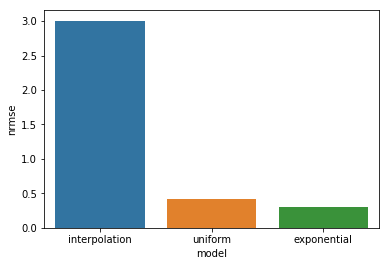

In [49]:
def check_for_duplicates(lst, UnqLst = True, verbose = True):
    lst_tmp = []
    duplicates = []
    for i in lst:
        if i in lst_tmp:
            
            duplicates += [i]
        else:
            lst_tmp += [i]
    if verbose == True:
        print(duplicates)
    if UnqLst:
        return(lst_tmp)
experiments1k = [
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt"]

for i in experiments1k:
    experiment_ = load_data(i,
                             bp = './experiment_results/')
    hi = pd.DataFrame(experiment_['nrmse'], index = [0])
    hi = pd.melt(hi)
    hi.columns = ["model", "nrmse"]
    print(hi)
    sns.barplot(x = "model", y = "nrmse", data = hi)
    #experiment_obj = get_experiment(experiment_5)

In [59]:
"""
            finished but publish size:
            '/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.1.txt',
            "/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.25.txt",
            
            ########################################################################### 1k
            completed 1k tests
            "/1k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt",
"""

def quick_write_path(freq, split, targHz, obsHz, size = "/medium"):
    if freq == 2000:
        freqStr = "2k"
    elif freq == 4000:
        freqStr = "4k"
    splitStr = "/split_" + str(split)
    targHz, obsHz = str(targHz/1000) , str(obsHz/1000)
    HzStr = "/targetKhz:_" + targHz + "__obskHz:_" +  obsHz 
    newPath = freqStr + size + splitStr + HzStr +".txt"
    return([newPath])

def quick_write_dict(freq, split, targHz, obsHz):
    dict_tmp = {'target_freq': freq, 'split': split, 'obs_hz': obsHz, 'target_hz': targHz}
    return([dict_tmp])


path_lst = []
dict_lst = []
for targ_freq in [2000, 4000]:
    for split in [0.5, 0.9]:
        for targ in list(range(500, 2001, 250)):
            for obs in list(range(500, 2001, 250)):
                path_lst += quick_write_path(freq = targ_freq, split = split, targHz = targ, obsHz = obs)
                dict_lst += quick_write_dict(freq = targ_freq, split = split, targHz = targ, obsHz = obs)


path_lst += [ 
            # the plan is to run all those tests which will give detail from the LHS. ie increasin
            # target Hz.
            ########################################################################### 2k
            #######################2k, 0.9 
            #targ 500  kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.75.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.25.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.75.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_2.0.txt',
            
    
            

            #targ 750  H z
            '2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.75__obskHz:_1.0.txt',
    
            #targ 1000 kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
            
            #targ 1250  Hz
            '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_0.5.txt', 
            '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_1.0.txt', 
    
            #targ 1500  Hz
            '2k/medium/split_0.9/targetKhz:_1.5__obskHz:_0.5.txt', 
            '2k/medium/split_0.9/targetKhz:_1.5__obskHz:_1.0.txt', 
    
            #targ 1750  Hz
            '2k/medium/split_0.9/targetKhz:_1.75__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.75__obskHz:_1.0.txt',
    
            #targ 2000  Hz
            '2k/medium/split_0.9/targetKhz:_2.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_2.0__obskHz:_1.0.txt',
    
            #######################2k, 0.5
            #targ 500  Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.75.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.25.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.5.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.75.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_2.0.txt',
    
             #targ 750 Hz
             "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",
             "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt", #CHECK LATER
    
            #targ 1000 Hz
             "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt", #
             "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt", #
    
            #targ 1250 Hz
             "2k/medium/split_0.5/targetKhz:_1.25__obskHz:_1.0.txt", # ABOUT TO RUN 600
             "2k/medium/split_0.5/targetKhz:_1.25__obskHz:_0.5.txt", # ABOUT TO RUN 600
    
            #targ 1500 Hz
             "2k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt", # ABOUT TO RUN 1000
             "2k/medium/split_0.5/targetKhz:_1.5__obskHz:_0.5.txt", # ABOUT TO RUN 1000
    
     
             #targ 2000 Hz
             '2k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt', #no exp
             
    
           ########################################################################### 4k
           #######################4k, 0.9 
           #4k, 0.9 500 target Hz COMPLETE
           "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
           "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            
           #4k, 0.9 1000 target Hz RUNNING
           '4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt', #RUNNING 200
           '4k/medium/split_0.9/targetKhz:_0.75__obskHz:_1.0.txt', #RUNNING 200
    
           
           #4k, 0.9 1000 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
           '4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
    
           #4k, 0.9 1250 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.25__obskHz:_0.5.txt', #RUNNING 400
           '4k/medium/split_0.9/targetKhz:_1.25__obskHz:_1.0.txt', #RUNNING 400
           
           #4k, 0.9 1500 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.5__obskHz:_0.5.txt', #RUNNING 700
           '4k/medium/split_0.9/targetKhz:_1.5__obskHz:_1.0.txt', #RUNNING 700
            

           #######################4k, 0.5
           #4k 0.5 target kHz COMPLETE
           '4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt', #???
           "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt",  #???
    
           #4k 0.75 target kHz COMPLETE
           "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt", #NO EXP
           "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",  
           
           #4k 1.0 target kHz 
           "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",# ????
           "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt",   # ALREADY HAVE IT
    
           #4k, 0.5 1250 target Hz NEED TO RUN
           '4k/medium/split_0.5/targetKhz:_1.25__obskHz:_0.5.txt', #ABOUT TO RUN 500
           '4k/medium/split_0.5/targetKhz:_1.25__obskHz:_1.0.txt', #ABOUT TO RUN 500
    
            #4k, 0.5 1500 target Hz NEED TO RUN
           '4k/medium/split_0.5/targetKhz:_1.5__obskHz:_0.5.txt', #ABOUT TO RUN 900
           '4k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt', #NO EXP

           #4k 2.0 target kHz 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_0.5.txt", 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt", 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.5.txt", #For now this is deemed unessential.
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_2.0.txt", 

           #4k 0.5, bigger and better! 

           #"2k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt", 


           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_0.5.txt",
           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_1.0.txt",
           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_2.0.txt",

           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_0.5.txt", #??? broken
           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_1.0.txt", #??? broken
           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_2.0.txt", #??? broken

           #"4k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",

           # MORE DETAIL:, given that the others aren't converging. 
         ]
path_lst_unq = check_for_duplicates(path_lst, verbose = False)
dict_lst_unq = check_for_duplicates(dict_lst, verbose = False)
#display(path_lst_unq)
complete_experiment_path_lst = path_lst_unq
#complete_experiment_path_lst = experiments1k

In [63]:
assert(check_for_duplicates(complete_experiment_path_lst) != True), "duplicates found"

bp_ = "./experiment_results/"



for i, path in enumerate(complete_experiment_path_lst):
    if i ==0:
        experiment_lst = []
        NOT_INCLUDED = []
        NOT_YET_RUN = []
    else: 
        try:
            spec_json = load_data(path, bp = bp_, verbose = False)
            models_spec = list(spec_json["prediction"].keys())
            try:
                assert len(models_spec) >= 3
                assert "exponential" in models_spec
                
                experiment_lst.append(spec_json)
            except:
                NOT_INCLUDED += [i]
        except:
            NOT_YET_RUN +=[i]

if NOT_YET_RUN != []:
    print(NOT_YET_RUN)
    print("the following paths have not yet been run: ")
    print(np.array(dict_lst_unq)[NOT_YET_RUN])
       

#experiment_lst = [ load_data(path, bp = bp_, verbose = False) for path in complete_experiment_path_lst]


# fix nrmse calculation:
for i in range(len(experiment_lst)):
    #print(i)
    hi_train_set, hi_test_set = recover_test_set(experiment_lst[i]) 
    models_spec = list(experiment_lst[i]["prediction"].keys())

    for model_ in models_spec:
        pred_ = experiment_lst[i]["prediction"][model_]
        corrected_nrmse = nrmse(pred_, hi_test_set)
        experiment_lst[i]["nrmse"][model_] =corrected_nrmse
        #print(experiment_lst[i]["nrmse"][model_] )
        

   
        
if NOT_INCLUDED != []:
    print("the following paths contain incomplete experiments: (only unif finished)")
    print(np.array(path_lst_unq)[NOT_INCLUDED])
    print(np.array(dict_lst_unq)[NOT_INCLUDED])
    

[]
[1, 3, 4, 5, 6, 8, 10, 11, 12, 13, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 50, 52, 53, 54, 55, 57, 59, 60, 61, 62, 64, 66, 67, 68, 69, 74, 75, 76, 78, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 101, 102, 103, 104, 106, 108, 109, 110, 111, 115, 116, 117, 118, 120, 122, 123, 124, 125, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 143, 144, 145, 148, 150, 151, 152, 153, 155, 157, 158, 159, 160, 162, 164, 165, 166, 167, 169, 171, 172, 173, 174, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195]
the following paths have not yet been run: 
[{'target_freq': 2000, 'split': 0.5, 'obs_hz': 750, 'target_hz': 500}
 {'target_freq': 2000, 'split': 0.5, 'obs_hz': 1250, 'target_hz': 500}
 {'target_freq': 2000, 'split': 0.5, 'obs_hz': 1500, 'target_hz': 500}
 {'target_freq': 2000, 'split': 0.5, 'obs_hz': 1750, 'target_hz': 500}
 {'target_freq': 2000, 'sp

the following paths contain incomplete experiments: (only unif finished)
['2k/medium/split_0.5/targetKhz:_1.25__obskHz:_0.5.txt'
 '2k/medium/split_0.5/targetKhz:_1.25__obskHz:_0.75.txt'
 '2k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.25.txt'
 '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_0.5.txt'
 '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_0.75.txt'
 '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_1.0.txt'
 '2k/medium/split_0.9/targetKhz:_1.75__obskHz:_0.75.txt'
 '4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt'
 '4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.75.txt']
[{'target_freq': 2000, 'split': 0.5, 'obs_hz': 500, 'target_hz': 1250}
 {'target_freq': 2000, 'split': 0.5, 'obs_hz': 750, 'target_hz': 1250}
 {'target_freq': 2000, 'split': 0.5, 'obs_hz': 1250, 'target_hz': 2000}
 {'target_freq': 2000, 'split': 0.9, 'obs_hz': 500, 'target_hz': 1250}
 {'target_freq': 2000, 'split': 0.9, 'obs_hz': 750, 'target_hz': 1250}
 {'target_freq': 2000, 'split': 0.9, 'obs_hz': 1000, 'target_hz'

In [53]:
def convert_pathLst2Dict():
    

['2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt',
 '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.75.txt',
 '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt',
 '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.25.txt',
 '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.5.txt',
 '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.75.txt',
 '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_2.0.txt',
 '2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt',
 '2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.75.txt',
 '2k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt',
 '2k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.25.txt',
 '2k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.5.txt',
 '2k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.75.txt',
 '2k/medium/split_0.5/targetKhz:_0.75__obskHz:_2.0.txt',
 '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt',
 '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.75.txt',
 '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt',
 '2k/medium/split_0.5/targetKhz:_1

[750, 1000, 1250, 1500, 1750, 2000]

In [38]:
IGNORE_IP = False


def quick_dirty_convert(lst):
    if IGNORE_IP == True:
        lst *= 2
    else:
        lst *= 3
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst, targ_freq_lst = [], [], []

for i, experiment in enumerate(experiment_lst):
    #print(experiment['experiment_inputs'].keys())
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    targ_freq = experiment["experiment_inputs"]['target_frequency']
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    targ_freq_lst += [targ_freq]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec= experiment["nrmse"]
    
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    df_spec_rel = df_spec.copy()
    #/df_spec_diff["uniform"]
    #df_spec_diff["rc_diff"]
    
    if IGNORE_IP == True:
        df_spec_rel = df_spec_rel / experiment["nrmse"]["uniform"]#
    else:
        df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]

   
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df      = df_spec
        df_rel  = df_spec_rel

        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])


df_net = df_rel.copy()
        
obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
targ_freq_lst = quick_dirty_convert(targ_freq_lst)
#display(df)
if IGNORE_IP == True:
    df_rel = df_rel.drop(columns = ["interpolation"])
    df  = df.drop(columns = ["interpolation"])
df_rel  = df_rel.drop(columns = ["hybrid"])
df      = df.drop(    columns = ["hybrid"])

df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst, targ_freq_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst, targ_freq_lst], axis = 1)

#df_diff = pd.concat( [idx_lst, df_diff,  obs_hz_lst, targ_hz_lst, targ_freq_lst], axis = 1)

col_names = ["experiment", "model", "nrmse", "obs hz", "target hz", "target freq" ]
df.columns, df_rel.columns    = col_names, col_names


odds of loss reduction with exponential weights vs uniform weights: 65.91%
mean % loss change: -8.0%


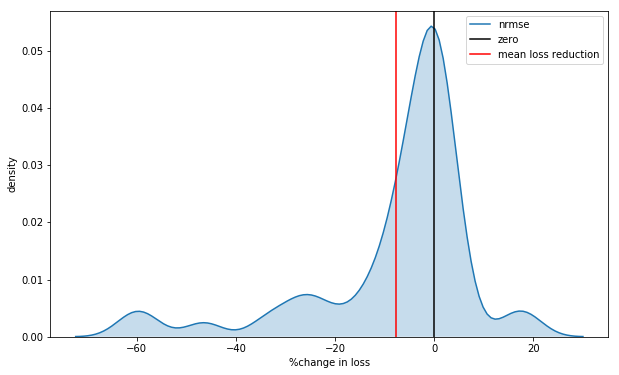

In [39]:
df_diff = df[df["model"] == "uniform"]
df_diff.model = "diff"
nrmse_ = (df[df["model"] == "exponential"]["nrmse"].values - df_diff["nrmse"].values) * 100
df_diff.nrmse = nrmse_
def plot_loss_reduction():

    df_diff = df[df["model"] == "uniform"]
    df_diff.model = "diff"
    #df_diff["nrmse"] = df_diff["nrmse"] - df[df["model"] == "exponential"]["nrmse"]

    #df[df["model"] == "exponential"] 

    nrmse_ = (df[df["model"] == "exponential"]["nrmse"].values - df_diff["nrmse"].values) * 100
    df_diff.nrmse = nrmse_
    pct = round(np.mean(nrmse_ < 0) * 100,2)
    print("odds of loss reduction with exponential weights vs uniform weights: " + str(pct) + "%")
    print("mean % loss change: " + str(round(np.mean(nrmse_))) + "%")

    #sns.catplot(x = "model", y = "nrmse", data = df_diff)
    fig, ax = plt.subplots(1,1,figsize = (10, 6))
    plt.xlabel("%change in loss")
    plt.ylabel("density")
    sns.kdeplot(df_diff["nrmse"], shade = True)
    plt.axvline(x=0, color = "black", label = "zero")
    plt.axvline(x=np.mean(df_diff["nrmse"]), color = "red", label = "mean loss reduction")
    
    plt.legend()
    plt.show()
plot_loss_reduction()

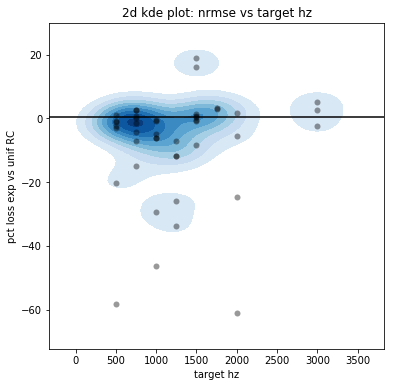

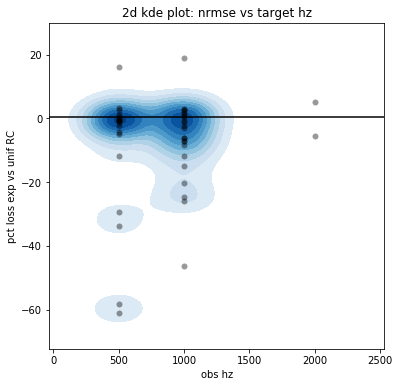

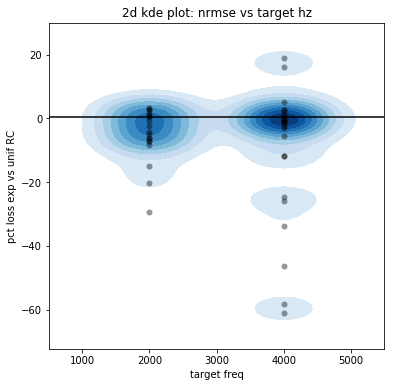

In [40]:
def plot_loss_reduction2d(xx = "target hz"):
    
    fig, ax = plt.subplots(1, 1, figsize = (6,6))
    sns.kdeplot(df_diff[xx], df_diff["nrmse"],
                     cmap="Blues", shade=True, shade_lowest=False, ax = ax)#, alpha = 0.5)
    #plt.ayvline(y=0, color = "black", label = "zero")
    sns.scatterplot(x = xx, y = "nrmse", data = df_diff, ax = ax,  linewidth=0, color = "black", alpha = 0.4)
    plt.title("2d kde plot: nrmse vs target hz")
    plt.axhline(y=0.5, color='black', linestyle='-')
    ax.set_ylabel("pct loss exp vs unif RC")
plot_loss_reduction2d()
plot_loss_reduction2d(xx = "obs hz")
plot_loss_reduction2d(xx = "target freq")

In [41]:
experiment_lst[0]['get_observer_inputs']

{'method': 'exact', 'split': 0.9, 'aspect': 0.9}

In [42]:
def time_R_plot(split = 0.5, exp_json_lst = experiment_lst):
    #exp stands for experiment here, not exponential
    
    for i, exp_json in enumerate(exp_json_lst):
        count = 0
        if exp_json['get_observer_inputs']["split"] == split:
        
            exp_obj = get_experiment(exp_json, compare = False, verbose = False, plot_split = False)


            #construct the required data frame and caculate the nrmse from the predictions:
            train_, test_ = recover_test_set(exp_json)
            for j, model in enumerate(["interpolation", "uniform","exponential"]):
                #R is new name for nrmse
                R_spec = nrmse(pred_ = exp_json["prediction"][model], truth = test_, columnwise = True)
                R_spec = pd.DataFrame({model : R_spec})
                if j == 0:
                    rDF_spec = R_spec
                else:
                    rDF_spec = pd.concat([rDF_spec, R_spec], axis = 1)
            #now I'm going to add an accurate axis label (time) and plot
            A = exp_obj.A

            train_len = A.shape[0] - exp_obj.prediction.shape[0]
            time_lst = list(exp_obj.T[train_len:].reshape(-1,))

            time_ = pd.Series(time_lst * 3) #len(list(exp_json["nrmse"].keys()))) #good



            rDF_spec = pd.melt(rDF_spec)
            rDF_spec["time"] = time_ 
            rDF_spec["experiment #"] = count
            rDF_spec.columns = ["model", "R", "time", "experiment #"]

            if count == 0:
                rDF = rDF_spec
            else:
                rDF = pd.concat([rDF, rDF_spec], axis = 0)
            count+=1
    
    display(rDF)
    sns.lineplot( x = "time", y = "R" , hue = "model" , data = rDF)
    plt.show()
    fig, ax = plt.subplots(1, 1, figsize = (12, 6))
    sns.lineplot( x = "time", y = "R" , hue = "model" , data = rDF)
    plt.ylim(0,1)
#time_R_plot()

In [43]:
display(df)

,experiment,model,nrmse,obs hz,target hz,target freq
0,0,interpolation,2.435104,1000.0,500.0,2000
1,1,interpolation,4.270364,500.0,750.0,2000
2,2,interpolation,3.456511,1000.0,750.0,2000
3,3,interpolation,4.045366,500.0,1000.0,2000
4,4,interpolation,3.926023,1000.0,1000.0,2000
...,...,...,...,...,...,...
127,39,exponential,0.750688,1000.0,2000.0,4000
128,40,exponential,0.948068,2000.0,2000.0,4000
129,41,exponential,0.689206,500.0,3000.0,4000
130,42,exponential,0.719622,1000.0,3000.0,4000


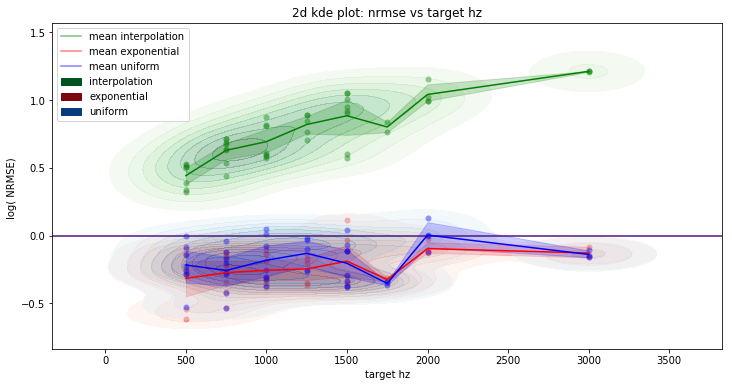

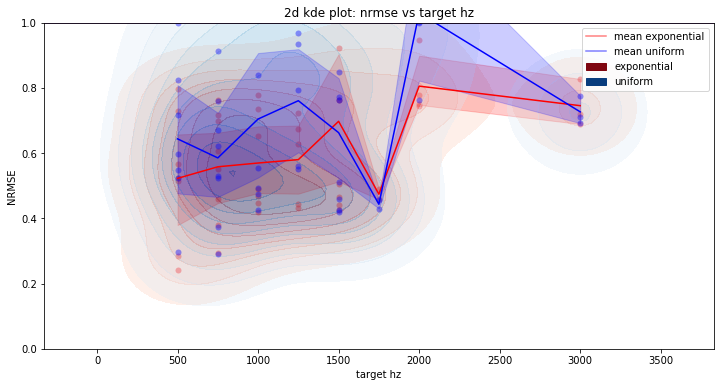

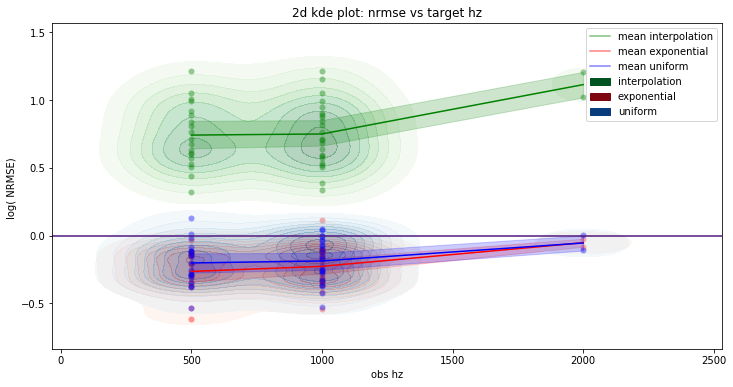

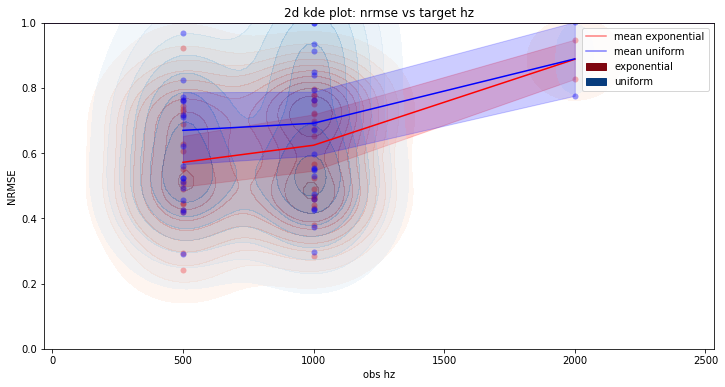

In [44]:
def plot_nrmse_kde_2d(xx = "target hz", 
                      log = True, 
                      alph = 1, 
                      black_pnts = True, 
                      models = {"Interpolation" : "Greens", "exponential" : "Reds"},
                      enforce_bounds = False,
                      target_freq = None):
    """
    #todo description
    """
    if target_freq != None:
        df_spec = df[df["target freq"] == target_freq]
    else:
        df_spec = df.copy()
            
    fig, ax = plt.subplots(1, 1, figsize = (12,6))
    def plot_(model_, colorr, alph = alph,  black_pnts =  black_pnts):
        if colorr == "Blues":
            color_ = "blue"
        elif colorr == "Reds":
            color_ = "red"
        elif colorr == "Greens":
            color_ = "green"
            
        df_ = df_spec[df_spec.model == model_] #df_ip  = df[df.model == "interpolation"]
        
        
            
        
        hi = df_["nrmse"]
        cap = 1
        if log == True:
            hi = np.log(hi)/ np.log(10)
            cap = np.log(cap) / np.log(10)
        
        
        sns.kdeplot(df_[xx], hi, cmap= colorr, 
                    shade=True, shade_lowest=False, ax = ax, label = model_, alpha = alph)#, alpha = 0.5)
        
        if  black_pnts == True:
            col_scatter = "black"
        else:
            col_scatter = color_
        
        sns.scatterplot(x = xx, y = hi, data = df_,  linewidth=0, 
                        color = col_scatter, alpha = 0.4, ax = ax)
        
        plt.title("2d kde plot: nrmse vs target hz")
        
        plt.axhline(y=cap, color=color_, linestyle='-', label = "mean " + str(model_), alpha = 0.5)
        sns.lineplot(y = hi, x = xx, data = df_ , color = color_)#, alpha = 0.2)
        if enforce_bounds == True:
            ax.set_ylim(0,1)
        if log == True:
            ax.set_ylabel("log( NRMSE) ")
        else: 
            ax.set_ylabel("NRMSE")
    for model in list(models.keys()):
        plot_(model, models[model], alph = alph)
    #plot_("interpolation", "Blues")
    #plot_("exponential", "Reds", alph = alph)
def kde_plots(target_freq = None, ):
    
    additional_arguments ={ "black_pnts" : False, 
                           "alph" : 0.3, 
                           "target_freq" : target_freq}
    
    plot_nrmse_kde_2d(**additional_arguments, 
                      models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"})
    plot_nrmse_kde_2d(**additional_arguments, log = False, 
                      models = {"exponential" : "Reds", "uniform" : "Blues"},
                     enforce_bounds = True)
    plot_nrmse_kde_2d(xx = "obs hz", **additional_arguments, 
                      models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"})
    plot_nrmse_kde_2d(xx = "obs hz", **additional_arguments, log = False, 
                      models = {"exponential" : "Reds", "uniform" : "Blues"},
                     enforce_bounds = True)


kde_plots()


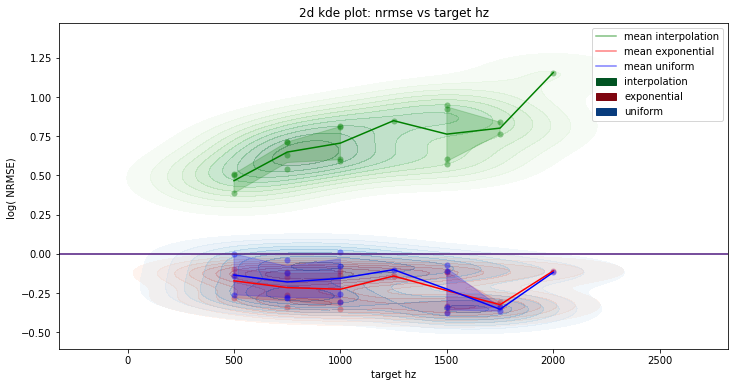

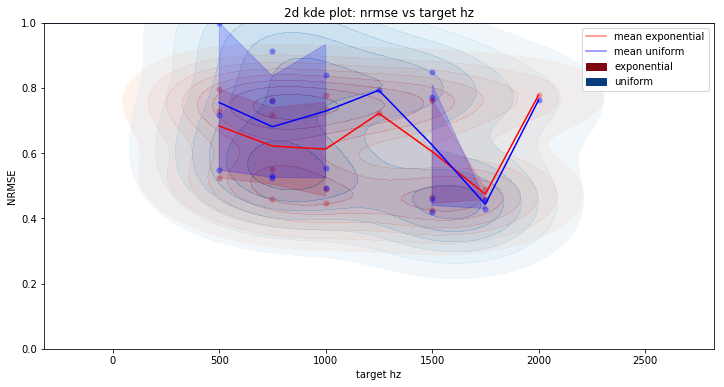

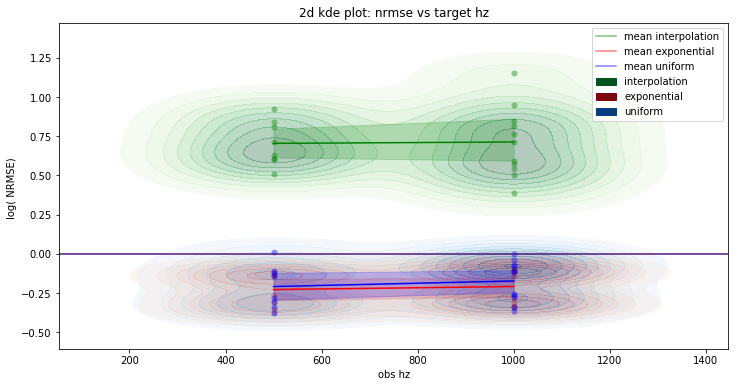

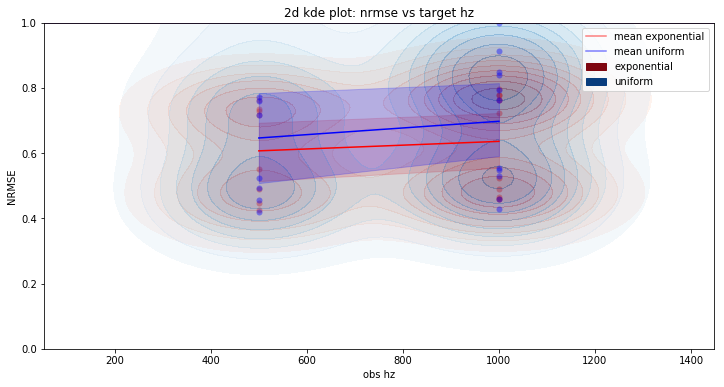

In [45]:
kde_plots(target_freq = 2000)

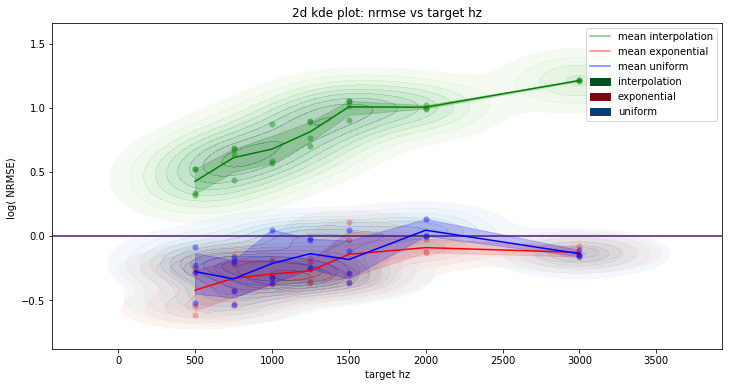

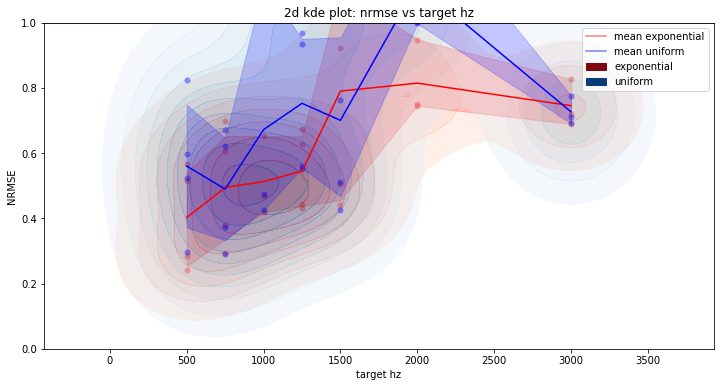

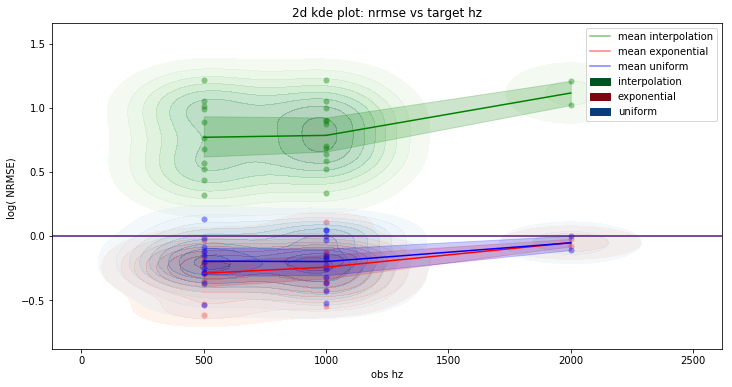

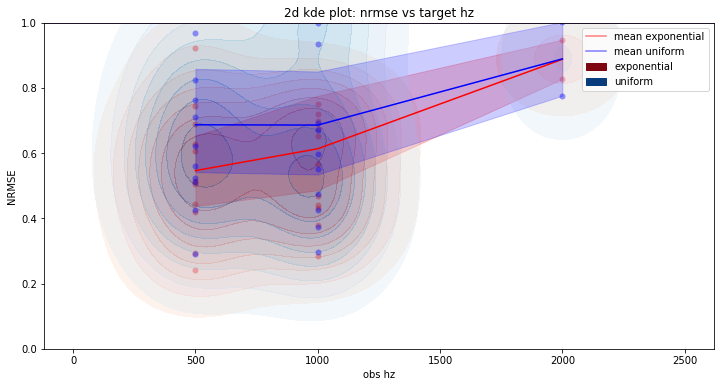

In [46]:
kde_plots(target_freq = 4000)

Text(0, 0.5, 'Relative NRMSE')

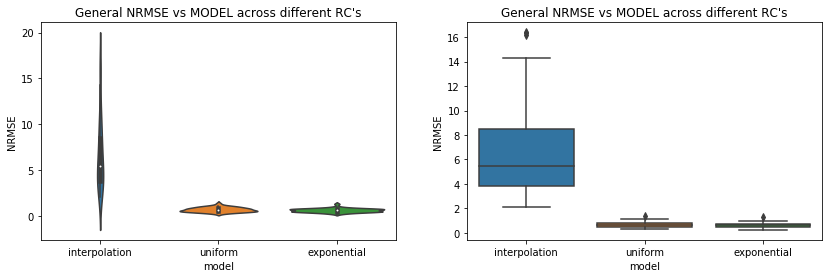

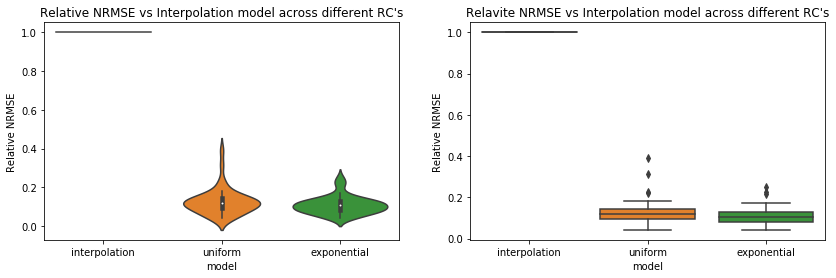

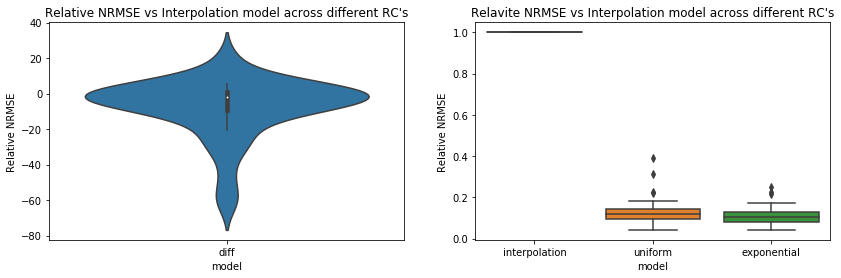

In [17]:



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")
ax[0].set_ylabel("NRMSE"); ax[1].set_ylabel("NRMSE")



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")
ax[0].set_ylabel("Relative NRMSE"); ax[1].set_ylabel("Relative NRMSE")

fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_diff, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")
ax[0].set_ylabel("Relative NRMSE"); ax[1].set_ylabel("Relative NRMSE")


Text(0.5, 1.0, "Relavite NRMSE vs Interpolation model across different RC's")

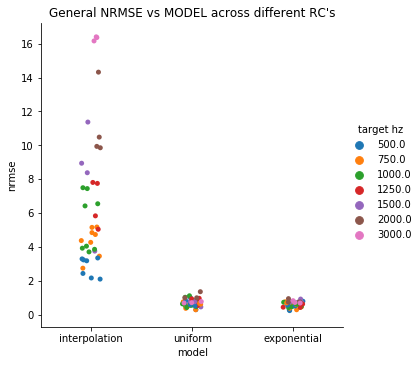

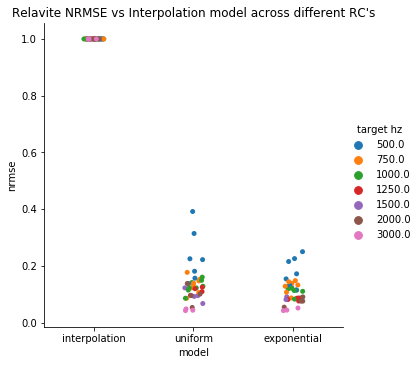

In [72]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

Text(0, 0.5, 'NRMSE')

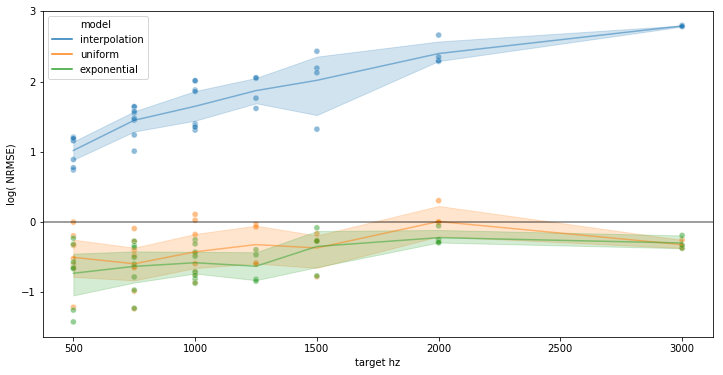

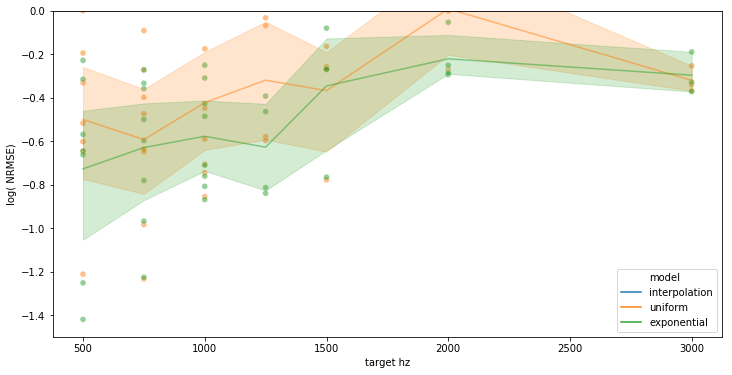

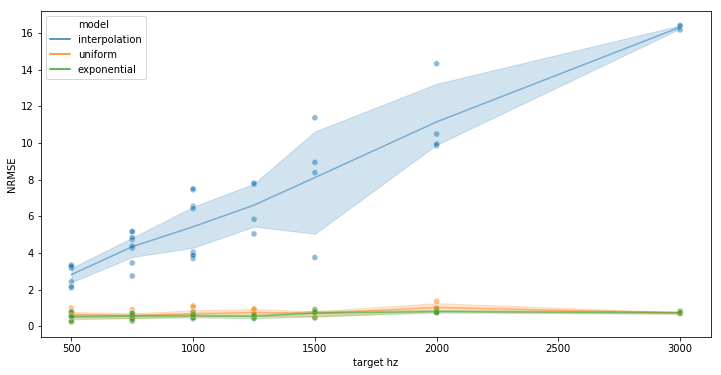

In [73]:
hi = np.log(df["nrmse"])
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
cap = np.log(1.0)/np.log(10)
plt.axhline(y=cap, color="black", linestyle='-', label = "mean " + str(model_), alpha = 0.5)
plt.ylabel("log( NRMSE)")

fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
cap = np.log(1.0)/np.log(10)
plt.axhline(y=cap, color="black", linestyle='-', label = "mean " + str(model_), alpha = 0.5)
plt.ylabel("log( NRMSE)")
plt.ylim((-1.5,cap))



hi = df["nrmse"]
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
plt.ylabel("NRMSE")

Text(0, 0.5, 'Log ( NRMSE )')

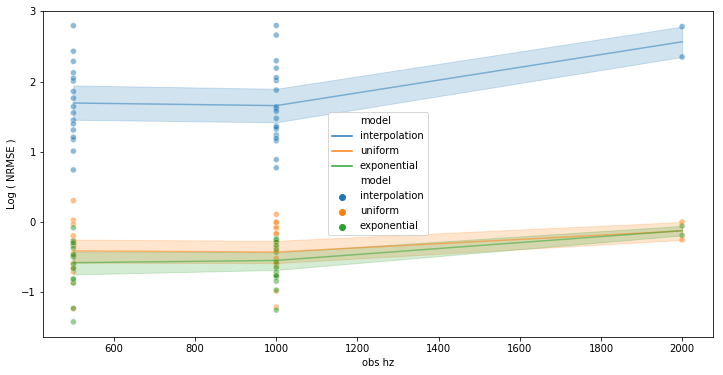

In [74]:
hi = np.log(df["nrmse"])
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "obs hz", data = df, hue = "model", alpha = 0.5)
sns.lineplot( y = hi, x = "obs hz", data = df, hue = "model", alpha = 0.5)
ax.set_ylabel("Log ( NRMSE )")

Text(0.5, 1.0, "Relavite NRMSE vs Interpolation model across different RC's")

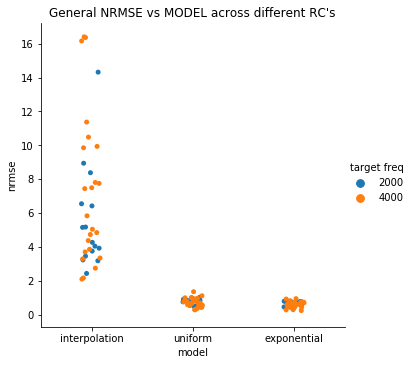

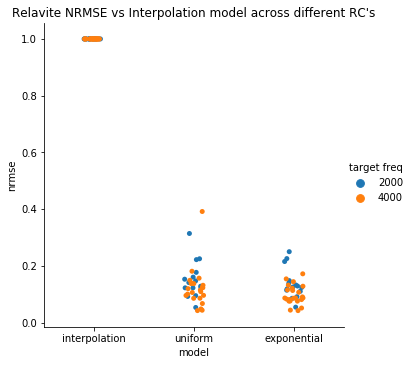

In [75]:
sns.catplot(y = "nrmse" , x = "model", hue ="target freq", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target freq", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

Text(0.5, 1.0, "Relavite NRMSE vs Interpolation model across different RC's")

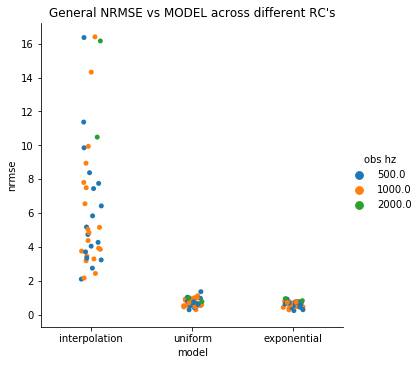

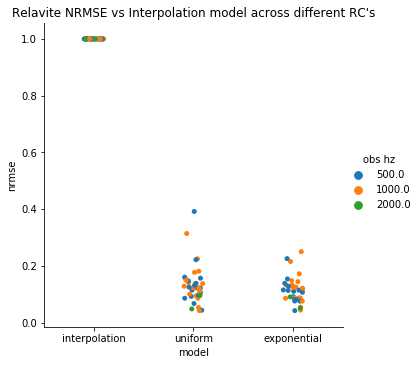

In [76]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

uniform


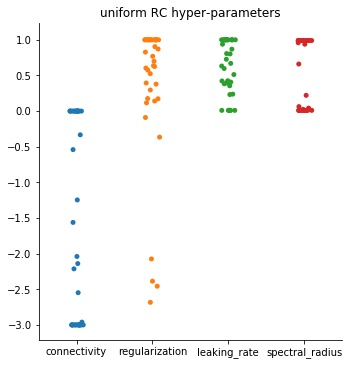

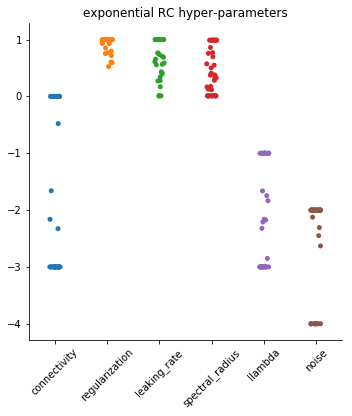

In [77]:
def hyper_parameter_plot(experiment_lst):
    """
    Let's visualize the hyper-parameter plots.
    """
    log_vars = ["noise", "connectivity", "regularization", "llambda"]
    
    for i, experiment in enumerate(experiment_lst):
        df_spec_unif = pd.DataFrame(experiment["best arguments"]["uniform"], index = [0])
        df_spec_exp  = pd.DataFrame(experiment["best arguments"]["exponential"], index = [0])
        if i == 0:
            df_unif = df_spec_unif
        else:
            df_unif = pd.concat([df_unif, df_spec_unif])
        if i == 0:
            df_exp = df_spec_exp
        else:
            df_exp = pd.concat([df_exp, df_spec_exp])
    print("uniform")
    unif_vars = ["connectivity", "regularization", "leaking_rate", "spectral_radius"]
    exp_vars  = ["llambda", "noise"]
    df_unif = df_unif[unif_vars]
    df_exp = df_exp[unif_vars + exp_vars]
    
    for i in list(df_unif.columns):
        if i in log_vars:
            df_unif[i] = np.log(df_unif[i])/np.log(10)
            
    for i in list(df_exp.columns):
        if i in log_vars:
            df_exp[i] = np.log(df_exp[i])/np.log(10)
    
    
    #display(df_unif)
    
    sns.catplot(data = df_unif)
    plt.title("uniform RC hyper-parameters")
    plt.show()
    
    
    sns.catplot(data = df_exp)
    plt.title("exponential RC hyper-parameters")
    plt.xticks(rotation=45)
    plt.show()

    #display(df_exp)
   
hyper_parameter_plot(experiment_lst)

# Old experiments

In [ ]:
experiment_1 = topline("split_0.9/targetKhz:_0.5__obskHz:_0.5.txt", print_filestructure = False)
#hh = load_data()
#print(loadA.shape)
experiment_1_obj = get_experiment(experiment_1)


experiment_2 = topline("split_0.9/targetKhz:_0.5__obskHz:_1.0.txt") 
experiment_2_obj = get_experiment(experiment_2)

fp_exp1 =  '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_1.0/exp_targetKhz:_0.5__obskHz:_1.0.txt'
fp_unif1 = '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_1.0/targetKhz:_0.5__obskHz:_1.0.txt'
experiment_3 =  merge_unif_exp(fp_unif = fp_unif1, fp_exp = fp_exp1)   
experiment_3_obj = get_experiment(experiment_3)


#0.5split_0.5_0.5
fp_unif1 =  '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_0.5/unif_targetKhz:_0.5__obskHz:_0.5.txt'
fp_exp1 = '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_0.5/targetKhz:_0.5__obskHz:_0.5.txt'
experiment_4 =  merge_unif_exp(fp_unif = fp_unif1, fp_exp = fp_exp1)   
experiment_4_obj = get_experiment(experiment_4)

experiment_5 = load_data('experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt',
                         bp = '/Users/hayden/Desktop/')
experiment_5_obj = get_experiment(experiment_5)

experiment_6 = load_data('experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt',
                        bp = '/Users/hayden/Desktop/')
experiment_6_obj = get_experiment(experiment_6)

experiment_7 = load_data('experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt',
                         bp = '/Users/hayden/Desktop/')
experiment_7_obj = get_experiment(experiment_7)

experiment_8 = load_data('experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt',
                        bp = '/Users/hayden/Desktop/')
experiment_8_obj = get_experiment(experiment_8)

In [ ]:
for i, experiment in enumerate(experiment_lst):
    #print(experiment['get_observer_inputs'].keys())
    split = experiment['get_observer_inputs']["split"]
    targ_hz = experiment['experiment_inputs']["target_hz"]
    targ_idx_LB, targ_idx_UB = experiment["resp_idx"][0], experiment["resp_idx"][-1]
    obs_hz = experiment['experiment_inputs']["obs_hz"]
    f = np.array(experiment_8_obj.f)
    obs_idx = experiment["obs_idx"] 

    obs_idx  = [int(j) for j in experiment["obs_idx"] ]
    obs_freq = [max(f) - f[j] for j in obs_idx]
    
    
    print("\nexperiment: " + str(i) + ", target hz: " + str(targ_hz) + ", obs hz: " + str(obs_hz) +
         ", split: " + str(split))

    
    print("target idx: [" + str(targ_idx_LB) + ", " + str(targ_idx_UB) + "]")
    print("target freq: [" + str(max(f) - f[targ_idx_LB]) + ", " + str(max(f) - f[targ_idx_UB]) + "]")
    print("obs idx: " + str(obs_idx))
    print("obs freq: " + str(obs_freq))
    print(experiment_8_obj.A.shape[0] - np.array(experiment["prediction"]["interpolation"]).shape[0])
    print(experiment_8_obj.A.shape[0])
    #print(experiment["resp_idx"])

In [ ]:
def show_exp_weights(json_obj, llambda = None):
    print(json_obj.keys())
    esn_ = EchoStateNetwork(**json_obj["best arguments"]["exponential"], plot = True)
    esn_.obs_idx  = json_obj["obs_idx"]
    esn_.resp_idx = json_obj["resp_idx"]
    if llambda != None:
        esn_.llambda = llambda
    esn_.get_exp_weights()


for i in experiment_lst:
    show_exp_weights(i)  
#show_exp_weights(experiment_2)  



In [ ]:
show_exp_weights(i, llambda = 10**-3) 

In [ ]:
10**-2 
np.log(10**-4)/np.log(10)


In [ ]:
experiment_lst = [experiment_1, experiment_2, experiment_3, experiment_4, 
                  experiment_5, experiment_6, experiment_7, experiment_8]

def quick_dirty_convert(lst):
    lst *= 3
    print(lst)
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst = [], []

for i, experiment in enumerate(experiment_lst):
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec = experiment["nrmse"]
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    df_spec_rel = df_spec.copy()
    df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df = df_spec
        df_rel = df_spec_rel
        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])

#obs_hz_lst  *= 3
#targ_hz_lst *= 3

obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
        
df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst], axis = 1)

df.columns     = ["experiment", "model", "nrmse", "obs hz", "target hz" ]
df_rel.columns = ["experiment", "model", "nrmse", "obs hz", "target hz"] 
display(df)



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")


fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")


In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
hi = topline("split_0.9/targetKhz:_1.0__obskHz:_1.0.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = topline("split_0.9/targetKhz:_1.0__obskHz:_0.5.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = load_data("experiment_results/2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")#topline("split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = topline("split_0.5/targetKhz:_0.5__obskHz:_0.5.txt")  #GOOD!
#get_experiment(hi)
get_experiment(hi)

In [ ]:


def merge_unif_exp(fp_unif, fp_exp):
    exp_dat = load_data(fp_exp)
    unif_dat = load_data(fp_unif)
    assert exp_dat["prediction"]["interpolation"] == unif_dat["prediction"]["interpolation"], "something is wrong!"
    joint_dat = unif_dat.copy()
    for i in ["prediction", "nrmse", "best arguments"]:
        exp_dict = {"exponential" : exp_dat[i]["exponential"]}
        joint_dat[i] = Merge(joint_dat[i], exp_dict)
    print(joint_dat["best arguments"])
        
     
    return(joint_dat)
#0.5_1.0


In [ ]:
experiment_lst =[experiment_1, experiment_2, experiment_3, experiment_4,
                 experiment_5, experiment_6, experiment_7, experiment_8
                ]

In [ ]:
hi = load_data('experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt')
get_experiment(hi) # broken

In [ ]:
experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt')
                         #bp = '/Users/hayden/Desktop/')
experiment_5_obj = get_experiment(experiment_5)

In [ ]:
display(df)
uniform_ = df_rel[df_rel.model == "uniform"]
exp_ = df_rel[df_rel.model == "exponential"]

fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.kdeplot(uniform_["target hz"], uniform_["nrmse"],
                 cmap="Reds", shade=True, shade_lowest=False, ax = ax[0])#, alpha = 0.5)
sns.kdeplot(exp_["target hz"], exp_["nrmse"],
                 cmap="Blues", shade=True, shade_lowest=False, ax = ax[1])#, alpha = 0.5)
ax[0].set_ylim(0,0.3)
ax[1].set_ylim(0,0.3)

